In [1]:
import matplotlib.pyplot as plt
from utils import *
from tensorflow.keras.optimizers import Adam
import pandas as pd
from skimage.io import imread

image_size = (768, 768) #(512,512) (720, 1280)
better_model = False
load_pretrained_weights = False

# losses = sparse_crossentropy_ignoring_last_label
# losses = dice_p_bce
losses = bce_logdice_loss

# metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}
# metrics = {'pred_mask' : [dice, true_positive_rate]}
metrics = {'pred_mask' : [dice_coef, 'binary_accuracy', true_positive_rate]}
backbone = 'mobilenetv2' #mobilenetv2, xception

NET = 'deeplab_' + backbone
PATH = '/mnt/deep_learning/'

n_classes = 1

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)

Num workers: 4
Backbone: mobilenetv2
Path to dataset: /mnt/deep_learning/
N classes: 1
Image size: (768, 768)


In [2]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 3
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 1000
AUGMENT_BRIGHTNESS = False

ship_dir = '/mnt/deep_learning/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
from skimage.morphology import label


In [3]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))

print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


56862 training masks
23927 validation masks


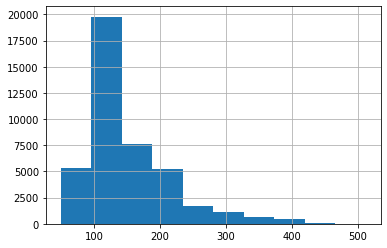

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids = unique_img_ids[unique_img_ids['has_ship']>0] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids,
                 test_size = 0.3)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1) // 2).clip(0, 7)

In [6]:
unique_img_ids.head()

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
2,000155de5.jpg,1,1.0,[1.0],147.625977
3,000194a2d.jpg,5,1.0,[1.0],75.221680
5,00021ddc3.jpg,9,1.0,[1.0],242.910156
6,0002756f7.jpg,2,1.0,[1.0],287.620117
9,00031f145.jpg,1,1.0,[1.0],232.898438


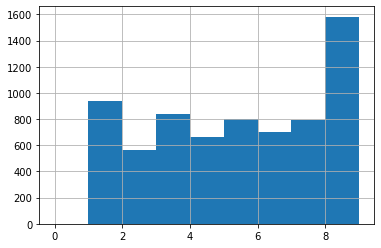

In [7]:
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep_val // 3)  # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0] < base_rep_val))


balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))


In [8]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [9]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [10]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 15,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

In [12]:
# brightness can be problematic since it seems to change the labels differently from the images
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

In [13]:
def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)


In [14]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


In [15]:
SegClass = SegModel(PATH, image_size)
SegClass.set_batch_size(BATCH_SIZE)

model = SegClass.create_seg_model(net='original',n=n_classes, load_weights=load_pretrained_weights,
                                      multi_gpu=False, backbone=backbone)

model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6),
              loss = losses, metrics = metrics)
print('Weights path:', SegClass.modelpath)
model.summary()

Weights path: /mnt/deep_learning//weights/mobilenetv2_original.h5
Model: "deeplabv3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768, 768, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 384, 384, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 384, 384, 32) 128         Conv[0][0]                       
_______________________

In [16]:
from tensorflow.keras import layers, models

# def upsample_simple(filters, kernel_size, strides, padding):
#     return layers.UpSampling2D(strides)

# upsample = upsample_simple

# input_img = layers.Input(t_x.shape[1:], name='RGB_Input')
# pp_in_layer = input_img
# pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
# pp_in_layer = layers.BatchNormalization()(pp_in_layer)

# c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
# c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
# p1 = layers.MaxPooling2D((2, 2))(c1)

# c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
# c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
# p2 = layers.MaxPooling2D((2, 2))(c2)

# c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
# c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
# p3 = layers.MaxPooling2D((2, 2))(c3)

# c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
# c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
# p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

# c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
# c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

# u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = layers.concatenate([u6, c4])
# c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
# c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

# u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = layers.concatenate([u7, c3])
# c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
# c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

# u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = layers.concatenate([u8, c2])
# c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
# c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

# u9 = upsample(8, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = layers.concatenate([u9, c1], axis=3)
# c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
# c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

# d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP), name="pred_mask")(d)
# if NET_SCALING is not None:
#     d = layers.UpSampling2D(NET_SCALING)(d)

# model = models.Model(inputs=[input_img], outputs=[d])

# model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6),
#               loss = losses, metrics = metrics)
# model.summary()

In [17]:
monitor = 'Jaccard'
mode = 'max'

def build_callbacks(tf_board = False):
    tensorboard = TensorBoard(log_dir='./logs/'+"airbus", histogram_freq=0,
                        write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = "/mnt/deep_learning/weights/airbus.h5", verbose=1, save_best_only=True, save_weights_only=True,
                                    monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,
                patience=5, min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks


In [18]:
callbacks = build_callbacks(tf_board = False)

In [19]:
import sys
oldStdout = sys.stdout
file = open('/mnt/deep_learning/logs/log.out', 'w')
sys.stdout = file

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']


In [20]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [model.fit_generator(aug_gen,
                             steps_per_epoch=step_count,
                             epochs=NB_EPOCHS,
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks,
                            workers=1 # the generator is not very thread safe
                                       )]

In [21]:
sys.stdout = oldStdout

In [24]:
# model.save("/mnt/deep_learning/weights/airbus.h5")

TypeError: can't pickle _thread.RLock objects

In [25]:
model

In [26]:
pred_y = model.predict(valid_x)

In [28]:
valid_x.shape

(400, 768, 768, 3)

In [29]:
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(400, 768, 768, 1) 3.0783525e-05 3.1639716e-05 3.0945444e-05


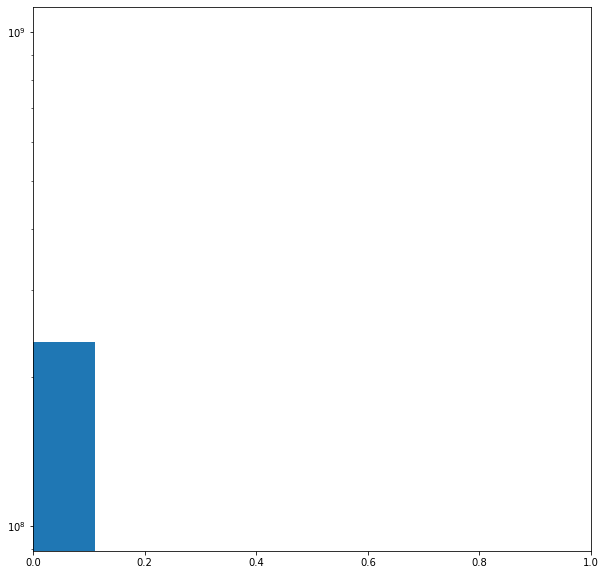

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

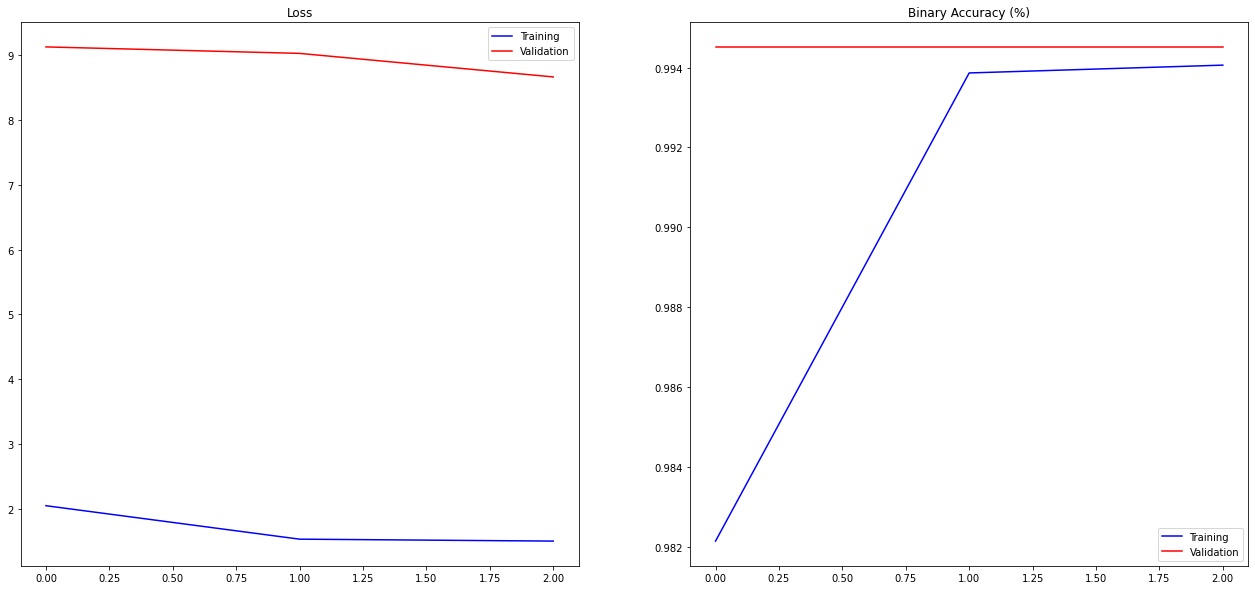

In [31]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [35]:
test_img = imread("{}/{}".format(train_image_dir, "00021ddc3.jpg"))

In [39]:
test_img_pred = np.expand_dims(test_img, axis = 0)# test_pred = model.predict(test_img, batch_size=1)

In [40]:
test_pred = model.predict(test_img_pred, batch_size=1)

In [43]:
test_pred[0].shape

(768, 768, 1)

9


Text(0.5, 1.0, 'Original Image')

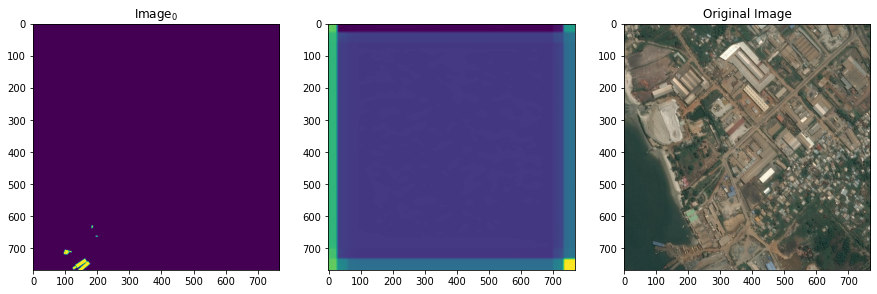

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels'] # an efficient way to filter against pandas dataframe
print(len(rle_0))
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
ax2.imshow(test_pred[0][:,:,0])
orig_img = plt.imread(os.path.join(train_image_dir, "00021ddc3.jpg"))
ax3.imshow(orig_img)
ax3.set_title('Original Image')

In [33]:
ax1.imshow(img_0[:, :, 0])

NameError: name 'ax1' is not defined

In [3]:
import os
ship_dir = '/mnt/deep_learning/'
test_image_dir = os.path.join(ship_dir, 'test_v2')


In [4]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

NameError: name 'valid_df' is not defined